In [56]:
import torch
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import tqdm as notebook_tqdm
import matplotlib.pyplot as plt

NUM_CLASSES = 6
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, 
                            n_features=NUM_FEATURES, 
                            centers=NUM_CLASSES, 
                            cluster_std=1.5, 
                            random_state=RANDOM_SEED)


X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2)

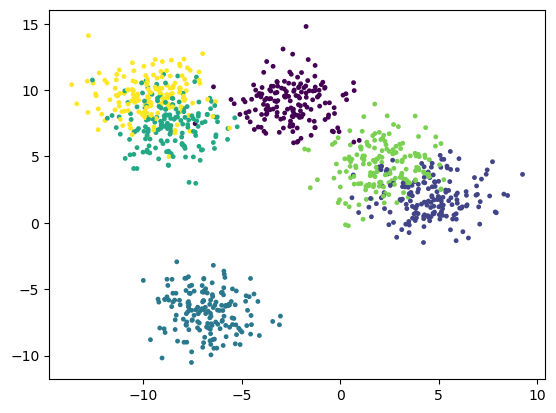

In [62]:
plt.scatter(x=X_blob[:, 0], y=X_blob[:, 1], c=y_blob, s=6, label="Training data")

In [112]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [96]:
# Build a model
import torch
from torch import nn
import numpy as np


class MultiClassModelV0ddf(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.layer_stack(x)

    
# V1
layer_sizes = [2, 10, 10, 10, 6]


def getSequentialLayer():
    layers = []
    for i in range(len(layer_sizes) - 1):
        
        in_features = layer_sizes[i]
        out_features = layer_sizes[i + 1]
        layer = nn.Linear(in_features, out_features)
        layers.append(layer)
        
        if(i < (len(layer_sizes) - 2)):
            layers.append(nn.ReLU())
    
    return layers
    
class MultiClassModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            *getSequentialLayer()
        )
    def forward(self, x):
        return self.layer_stack(x)
    
    
    
model_0 = MultiClassModelV1()


def normalizePredictions(y_pred):
    vals = torch.softmax(y_pred, dim=1)
    return torch.argmax(vals, dim=1)

        
model_0


MultiClassModelV1(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=6, bias=True)
  )
)

In [100]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss() # is combines BCE with sigmoid

optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.09)

In [101]:
from helpers import calculate_accuracy

model_0.eval()
with torch.inference_mode():
    # get prediction
    y_preds = model_0(X_test)
    y_preds_v = normalizePredictions(y_preds)
    
    print(y_preds_v[:10], y_train[:10])
    print(calculate_accuracy(y_test, y_preds_v))

tensor([0, 0, 2, 5, 0, 0, 2, 4, 5, 5]) tensor([5, 0, 3, 4, 1, 5, 1, 4, 4, 5])
83.5


In [109]:
# Training loop
torch.manual_seed(42)

epochs = 2000

train_epochs = []
train_loss_arr = []
test_loss_arr = []

train_acc_arr = []
test_acc_arr = []

for epoch in range(epochs):
    
    model_0.train();
    
    y_logits_train = model_0(X_train)
    
    y_pred_train = normalizePredictions(y_logits_train)
    
    train_acc = calculate_accuracy(y_train, y_pred_train)
    
    loss = loss_fn(y_logits_train, y_train)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_0.eval()
    
    with torch.inference_mode():
        
        y_test_logits = model_0(X_test)
        
        y_test_preds = normalizePredictions(y_test_logits)
        
        test_acc = calculate_accuracy(y_test, y_test_preds)
        
        test_loss = loss_fn(y_test_logits, y_test)
        
        
        if epoch % 100 == 0 :
            train_epochs.append(epoch)
            
            train_loss_arr.append(loss.item())
            test_loss_arr.append(test_loss.item())
            
            train_acc_arr.append(train_acc)
            test_acc_arr.append(test_acc)
            
            print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {train_acc} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc} ")
    
    

Epoch: 0 | Train Loss: 0.27415 | Train Acc: 88.625 | Test Loss: 0.26797 | Test Acc: 89.0 
Epoch: 100 | Train Loss: 0.27452 | Train Acc: 88.625 | Test Loss: 0.26805 | Test Acc: 89.0 
Epoch: 200 | Train Loss: 0.27365 | Train Acc: 88.625 | Test Loss: 0.26780 | Test Acc: 89.0 
Epoch: 300 | Train Loss: 0.26913 | Train Acc: 89.0 | Test Loss: 0.26624 | Test Acc: 88.0 
Epoch: 400 | Train Loss: 0.27363 | Train Acc: 88.625 | Test Loss: 0.26805 | Test Acc: 89.0 
Epoch: 500 | Train Loss: 0.27302 | Train Acc: 88.75 | Test Loss: 0.26780 | Test Acc: 88.5 
Epoch: 600 | Train Loss: 0.27274 | Train Acc: 88.75 | Test Loss: 0.26771 | Test Acc: 88.5 
Epoch: 700 | Train Loss: 0.26830 | Train Acc: 89.0 | Test Loss: 0.26555 | Test Acc: 88.0 
Epoch: 800 | Train Loss: 0.27314 | Train Acc: 88.625 | Test Loss: 0.26824 | Test Acc: 89.0 
Epoch: 900 | Train Loss: 0.27221 | Train Acc: 88.75 | Test Loss: 0.26773 | Test Acc: 88.5 
Epoch: 1000 | Train Loss: 0.27180 | Train Acc: 88.75 | Test Loss: 0.26762 | Test Acc: 88.

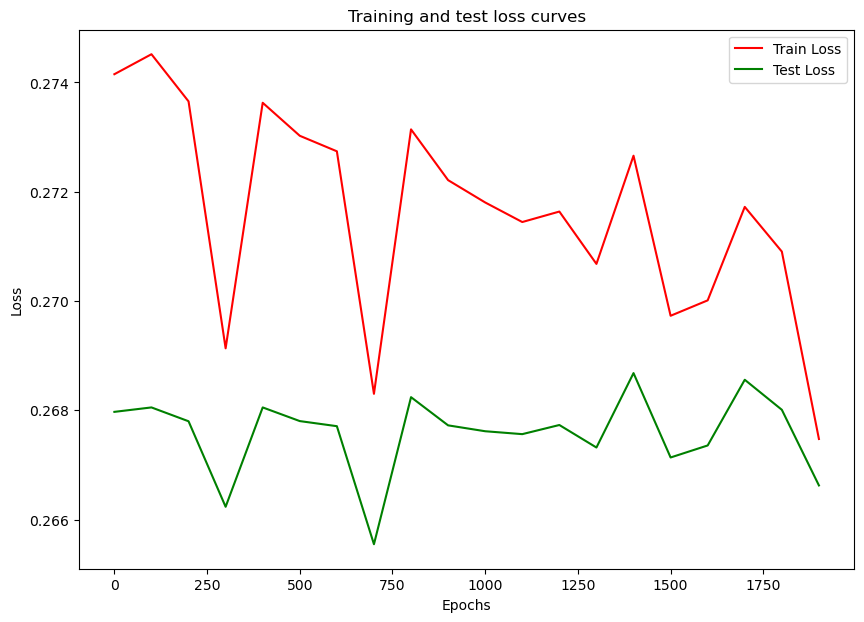

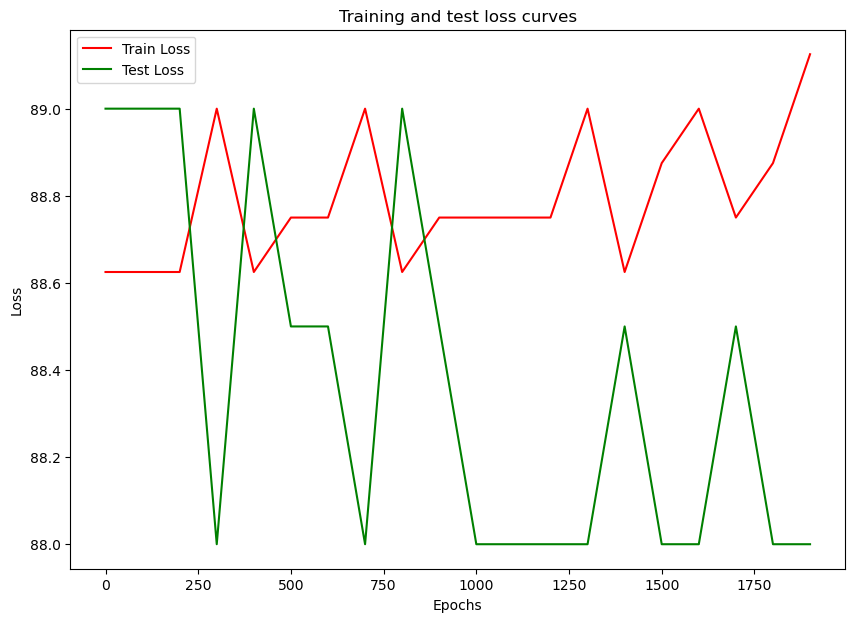

In [110]:
from helpers import plot_train_graph, plot_decision_boundary

plot_train_graph(x=train_epochs, y_train=train_loss_arr, y_test=test_loss_arr)

plot_train_graph(x=train_epochs, y_train=train_acc_arr, y_test=test_acc_arr)

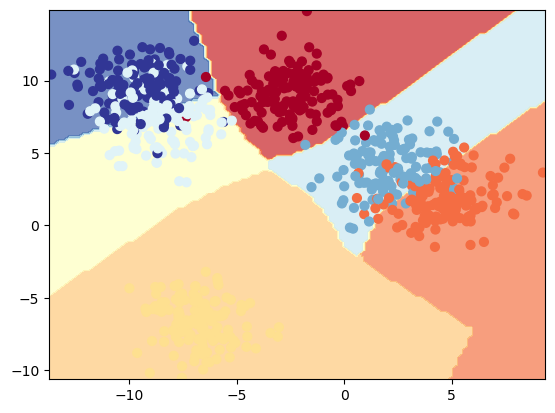

In [104]:
plot_decision_boundary(model_0, X_train, y_train)